In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Define improved transformations - less aggressive augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomResizedCrop(48, scale=(0.85, 1.0)),  # Less scaling
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(5),  # Reduced rotation
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Less translation/scaling
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # No random crop for validation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", transform=transform_train)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", transform=transform_val)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [3]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)  # Dropout after deeper conv blocks
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)  # Slightly higher dropout in deeper layers
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)  # Stronger dropout to combat overfitting
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout before the final output
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc(x)
        return x


Starting training...
Epoch: 1
Epoch 1/100, Loss: 1.7318, Accuracy: 32.47%
Current learning rate: 0.000300
Validation Loss: 1.5497
Epoch: 2
Epoch 2/100, Loss: 1.5251, Accuracy: 46.32%
Current learning rate: 0.000300
Validation Loss: 1.3900
Epoch: 3
Epoch 3/100, Loss: 1.4420, Accuracy: 50.95%
Current learning rate: 0.000300
Validation Loss: 1.3466
Epoch: 4
Epoch 4/100, Loss: 1.3909, Accuracy: 53.58%
Current learning rate: 0.000300
Validation Loss: 1.3035
Epoch: 5
Epoch 5/100, Loss: 1.3578, Accuracy: 55.64%
Current learning rate: 0.000300
Validation Loss: 1.2922
Epoch: 6
Epoch 6/100, Loss: 1.3365, Accuracy: 56.55%
Current learning rate: 0.000300
Validation Loss: 1.2771
Epoch: 7
Epoch 7/100, Loss: 1.3074, Accuracy: 58.13%
Current learning rate: 0.000300
Validation Loss: 1.2748
Epoch: 8
Epoch 8/100, Loss: 1.2909, Accuracy: 59.23%
Current learning rate: 0.000300
Validation Loss: 1.2656
Epoch: 9
Epoch 9/100, Loss: 1.2705, Accuracy: 59.82%
Current learning rate: 0.000300
Validation Loss: 1.234

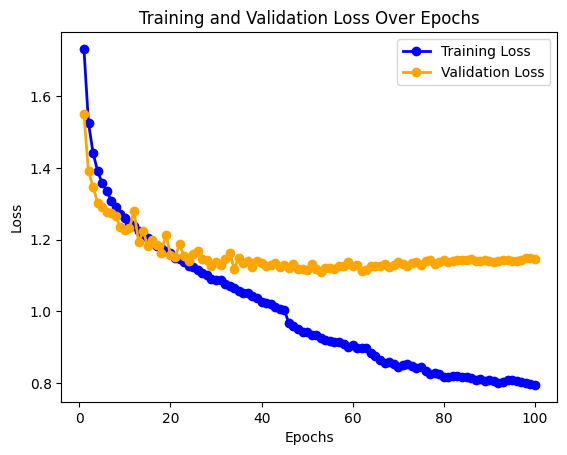

Training complete!
Validation Accuracy: 70.10%


In [5]:
# Initialize model, loss, and optimizer
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Apply label smoothing

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)

# Scheduler setup
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, min_lr=1e-6)

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

train_losses = []
val_losses = []

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Validation loss calculation
def compute_validation_loss():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loaded_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loaded_validation)

# Training function
def train_part(model, optimizer, epochs=10):
    model = model.to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for images, labels in loaded_train:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()

            # Mixed precision training
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

        # Calculate accuracy
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loaded_train):.4f}, Accuracy: {accuracy:.2f}%")
        print(f"Current learning rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

        # Compute validation loss and update scheduler
        val_loss = compute_validation_loss()
        print(f"Validation Loss: {val_loss:.4f}")
        scheduler.step(val_loss)
        train_losses.append(running_loss / len(loaded_train))
        val_losses.append(val_loss)

    # Plot training and validation losses
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue', linewidth=2, marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='orange', linewidth=2, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()


print("Starting training...")
train_part(model, optimizer, epochs=100)
print("Training complete!")

# Final validation accuracy
val_accuracy = evaluate_model(model, loaded_validation)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Target label: surprise


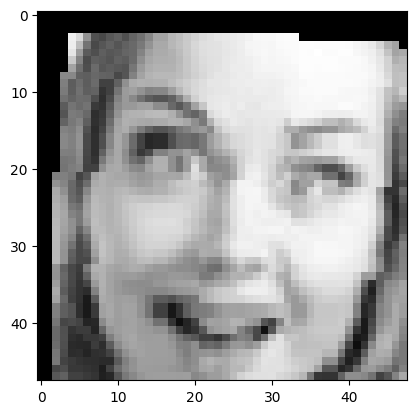

In [6]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


In [ ]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()